In [29]:
import numpy as np
import pandas as pd
import datetime

import math
from collections import defaultdict

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Visualization
from fbprophet import Prophet
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

In [30]:
df_eviction_3 = pd.read_csv('/Users/mightyhive/Desktop/Galvanize_Course/evictionprediction/Eviction_Data/Eviction_Notices.csv')
df_median_housingprice_3 = pd.read_csv('/Users/mightyhive/Desktop/Galvanize_Course/evictionprediction/Eviction_Data/med_sp_zip_code_sf_ca (1).csv')
df_census = pd.read_csv('/Users/mightyhive/Desktop/Galvanize_Course/evictionprediction/Eviction_Data/ACS_data_total.csv')
df_unemployment = pd.read_csv('/Users/mightyhive/Desktop/Galvanize_Course/evictionprediction/Eviction_Data/Unemployment_Rate.csv')
df_capital_improvements = pd.read_csv('/Users/mightyhive/Desktop/Galvanize_Course/evictionprediction/Eviction_Data/Petitions_to_the_Rent_Board.csv')

In [31]:
df_eviction_3.columns

Index([u'Eviction ID', u'Address', u'City', u'State',
       u'Eviction Notice Source Zipcode', u'File Date', u'Non Payment',
       u'Breach', u'Nuisance', u'Illegal Use', u'Failure to Sign Renewal',
       u'Access Denial', u'Unapproved Subtenant', u'Owner Move In',
       u'Demolition', u'Capital Improvement', u'Substantial Rehab',
       u'Ellis Act WithDrawal', u'Condo Conversion', u'Roommate Same Unit',
       u'Other Cause', u'Late Payments', u'Lead Remediation', u'Development',
       u'Good Samaritan Ends', u'Constraints Date', u'Supervisor District',
       u'Neighborhoods - Analysis Boundaries', u'Location', u'Address_Zipcode',
       u'Match_Landlord_Tenant_ZIP', u'Specific_Address'],
      dtype='object')

In [32]:
df_eviction = pd.read_csv('/Users/mightyhive/Desktop/Galvanize_Course/evictionprediction/Eviction_Data/Eviction_Notices.csv')
df_median_housingprice = pd.read_csv('/Users/mightyhive/Desktop/Galvanize_Course/evictionprediction/Eviction_Data/med_sp_zip_code_sf_ca (1).csv')
df_census = pd.read_csv('/Users/mightyhive/Desktop/Galvanize_Course/evictionprediction/Eviction_Data/ACS_data_total.csv')
df_unemployment = pd.read_csv('/Users/mightyhive/Desktop/Galvanize_Course/evictionprediction/Eviction_Data/Unemployment_Rate.csv')


def eviction_datetime_shift (df_eviction):

    df_eviction['File Date'] = pd.to_datetime(df_eviction['File Date'])
    df_eviction['start_of_month_datetime'] = df_eviction['File Date']-pd.offsets.MonthBegin(1)
    df_eviction['Address_Zipcode'] = df_eviction['Address_Zipcode'].apply(lambda x:0 if pd.isnull(x) else x)
    df_eviction['Address_Zipcode'] = df_eviction['Address_Zipcode'].astype(int).astype(str)
    df_eviction['Address_Zipcode'] = df_eviction['Address_Zipcode'].apply(lambda x:'Unknown_ZIP' if x=='0' else x)

    df_eviction = df_eviction.groupby(['start_of_month_datetime', 'Address_Zipcode']).sum().reset_index()
    df_eviction['Year'] = df_eviction['start_of_month_datetime'].dt.year
    df_eviction['Month'] = df_eviction['start_of_month_datetime'].dt.month

    return df_eviction

def eviction_boolean_cleaning (df_eviction):

    df_eviction.replace(False,0,inplace=True)
    df_eviction.replace(True,1,inplace=True)
    df_eviction['Supervisor District'] = df_eviction['Supervisor District'].astype(str)
    df_eviction['Eviction_Notice'] = 1


    return df_eviction

def data_processing_eviction(df_eviction):
    '''Performs a variety of transformations on eviction data from DataSF:

    PARAMETERS
    ----------
    df_eviction: Pandas DataFrame of eviction data from here:'''

    boolean_cleaned = eviction_boolean_cleaning(df_eviction)
    datetime_shifted = eviction_datetime_shift(boolean_cleaned)

    return datetime_shifted

def housing_datetime_shift(df_median_housingprice):

    df_median_housingprice['period_begin']=pd.to_datetime(df_median_housingprice['period_begin'])
    df_median_housingprice['period_end']=pd.to_datetime(df_median_housingprice['period_end'])
    df_median_housingprice['one_month_prior']=df_median_housingprice['period_begin']-pd.offsets.MonthBegin(1)+pd.offsets.MonthEnd(1)
    df_median_housingprice['three_months_prior']=df_median_housingprice['period_begin']-pd.offsets.MonthBegin(3)+pd.offsets.MonthEnd(1)
    df_median_housingprice['six_months_prior']=df_median_housingprice['period_begin']-pd.offsets.MonthBegin(6)+pd.offsets.MonthEnd(1)
    df_median_housingprice['one_year_prior']=df_median_housingprice['period_begin']-pd.offsets.MonthBegin(12)+pd.offsets.MonthEnd(1)

    return df_median_housingprice

def housing_add_time_lags(df_median_housing_price,list_of_time_lags):

    for time_lag in list_of_time_lags:
        df_median_housing_price = pd.merge(df_median_housing_price,\
                                df_median_housing_price[['median_sale_price','zip_code','period_end']],\
                                how='left',left_on=['zip_code',time_lag],right_on=['zip_code','period_end'],\
                                suffixes=('','_'+time_lag))

    return df_median_housing_price

def housing_select_columns(df_median_housing_price,selected_columns):

    df_median_housing_price = df_median_housing_price[selected_columns]

    df_median_housing_price['zip_code']=df_median_housing_price['zip_code'].astype(str)

    return df_median_housing_price


def data_processing_housing(df_median_housing_price):
    '''Performs a variety of transformations on housing price data from Redfin.

    PARAMETERS
    ----------
    df_median_housing_price_2: Pandas data of median house prices in SF. From Redfin.
    '''

    datetime_shifted_df = housing_datetime_shift(df_median_housing_price)

    time_lagged_df = housing_add_time_lags(datetime_shifted_df, ['one_month_prior','three_months_prior',\
                                                                    'six_months_prior','one_year_prior'])
    columns_to_select = ['zip_code','period_begin',\
        'period_end','median_sale_price','one_month_prior',\
        'three_months_prior','six_months_prior','one_year_prior',\
        'median_sale_price_one_month_prior', 'median_sale_price_three_months_prior',\
        'median_sale_price_six_months_prior','median_sale_price_one_year_prior']

    selected_housing_df = housing_select_columns(time_lagged_df, columns_to_select)

    return selected_housing_df



def census_cleaning(df_census):

    df_census['population']=df_census['HC01_VC03'].astype(int)
    df_census['GEO.id2']= df_census['GEO.id2'].astype(str)

    return df_census


def merged_data_datetime_shift(merged_df):

    merged_df = merged_df.drop(['median_sale_price'], axis=1)

    merged_df['Month_S'] = merged_df['Month'].map(int)
    merged_df['Year_S'] = merged_df['Year'].map(int)
    merged_df['Month_Year']= pd.to_datetime(dict(year=merged_df.Year_S, month=merged_df.Month_S, day=1))
    merged_df['one_month_prior']=merged_df['Month_Year']-pd.offsets.MonthBegin(1)
    merged_df['one_year_prior']=merged_df['Year_S']-1
    merged_df['two_years_prior']=merged_df['Year_S']-2
    merged_df['three_years_prior']=merged_df['Year_S']-3
    merged_df['four_years_prior']=merged_df['Year_S']-4
    merged_df['five_years_prior']=merged_df['Year_S']-5
    merged_df['datetime_six_months_prior']=merged_df['Month_Year']-pd.offsets.MonthBegin(6)
    merged_df['datetime_one_year_prior']=merged_df['Month_Year']-pd.offsets.MonthBegin(12)
    # merged_df = pd.merge(merged_df,merged_df[['Eviction_Notice','Month_Year','zip_code']],\
    #                                             how='left', left_on=['one_month_prior','zip_code'],\
    #                                             right_on= ['Month_Year','zip_code'], \
    #                                             suffixes=('','_one_month_prior'))

    return merged_df

def census_merge(merged_df, df_census):

    merged_df = pd.merge(merged_df,df_census,how='left',left_on=['Address_Zipcode', 'one_year_prior'], right_on=['GEO.id2','Year'], suffixes=('','_year_prior'))
    merged_df = pd.merge(merged_df,df_census,how='left',left_on=['Address_Zipcode', 'two_years_prior'], right_on=['GEO.id2','Year'], suffixes=('','_two_years_prior'))
    merged_df = pd.merge(merged_df,df_census,how='left',left_on=['Address_Zipcode', 'three_years_prior'], right_on=['GEO.id2','Year'], suffixes=('','_three_years_prior'))
    merged_df = pd.merge(merged_df,df_census,how='left',left_on=['Address_Zipcode', 'four_years_prior'], right_on=['GEO.id2','Year'], suffixes=('','_four_years_prior'))
    merged_df = pd.merge(merged_df,df_census,how='left',left_on=['Address_Zipcode', 'five_years_prior'], right_on=['GEO.id2','Year'], suffixes=('','_five_years_prior'))
    merged_df = merged_df.rename(columns={'Estimate; RACE - One race - Black or African American':'Black_population_previous_year','Percent; RACE - One race - White':'percent_white_population_previous_year'})
    return merged_df

def unemployment_merge(merged_df,df_unemployment):

    df_unemployment['DATE'] = pd.to_datetime(df_unemployment.DATE)
    merged_df = pd.merge(merged_df,df_unemployment ,how ='left', left_on=['datetime_one_year_prior'], right_on=['DATE'], suffixes=('','_unemployment_year_prior'))
    merged_df = pd.merge(merged_df,df_unemployment ,how ='left', left_on=['datetime_six_months_prior'], right_on=['DATE'], suffixes=('','_unemployment_six_months_prior'))
    return merged_df

def housing_merge(df_eviction_processed,df_median_housing_price_processed):
    eviction_housing_merged_df = pd.merge(df_eviction_processed,df_median_housing_price_processed,how='left',\
        left_on=['Address_Zipcode','start_of_month_datetime'],\
        right_on=['zip_code','period_begin'])
    return eviction_housing_merged_df

def transform_merge_data(df_eviction,df_median_housing_price, df_census, df_unemployment):
    '''Performs a variety of transformations and merges with eviction and housing price data

    PARAMETERS
    ----------
    df_eviction: Pandas DataFrame of eviction data from here: https://data.sfgov.org/Housing-and-Buildings/Eviction-Notices/5cei-gny5
    df_median_housing_price: Pandas data of median house prices in SF. From Redfin.
    df_census: aggregated data from the American Community Survey: https://www.census.gov/programs-surveys/acs/
    df_unemployment: unemployment percentage by month for the city of SF: https://fred.stlouisfed.org/series/CASANF0URN'''

    df_eviction_processed = data_processing_eviction(df_eviction)
    df_median_housing_price_processed = data_processing_housing(df_median_housingprice)
    eviction_housing_merged_df = housing_merge(df_eviction_processed,df_median_housing_price_processed)
    datetime_shifted_df = merged_data_datetime_shift(eviction_housing_merged_df)
    cleaned_census_df = census_cleaning(df_census)
    census_merged_df = census_merge(datetime_shifted_df,cleaned_census_df)
    unemployment_merged_df= unemployment_merge(census_merged_df,df_unemployment)
    final_merged_df = unemployment_merged_df

    return final_merged_df


In [33]:
final_df = transform_merge_data(df_eviction_3, df_median_housingprice_3,df_census,df_unemployment)

/Users/mightyhive/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [34]:
plt.plot(final_df.groupby('Month_Year').sum().reset_index()['Month_Year'],final_df.groupby('Month_Year').sum().reset_index()['Eviction_Notice'].apply(lambda x: x/20.),label='Eviction Notices (Divided by 20)',color='#2c7fb8')
plt.plot(df_unemployment['DATE'], df_unemployment['CASANF0URN'], label='Unemployment Rate', color='#7fcdbb')
# plt.title('Eviction Notices v. Unemployment in San Francisco')
plt.xlabel('Months')
plt.ylabel('Eviction Notices')
plt.legend()

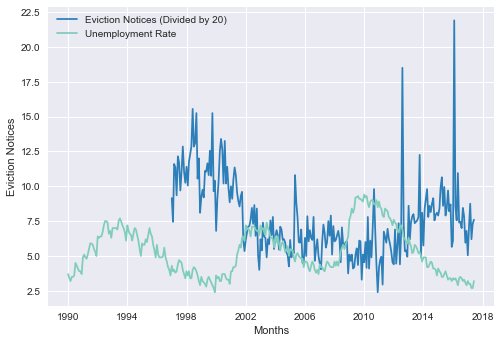

In [35]:
plt.show()

In [36]:
plt.plot(df_unemployment['DATE'], df_unemployment['CASANF0URN'])
df_unemployment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 2 columns):
DATE          330 non-null datetime64[ns]
CASANF0URN    330 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.2 KB


In [37]:
    merged_df = pd.merge(merged_df[['Month', 'Year', 'zip_code', 'median_sale_price_one_month_prior',\
        u'median_sale_price_three_months_prior',u'median_sale_price_six_months_prior',\
        u'median_sale_price_one_year_prior','Eviction_Notice', 'Month_Year', 'Month_S', 'Year_S','one_month_prior']],\
        merged_df[['Eviction_Notice','Month_Year','zip_code']], how='left', left_on=['one_month_prior','zip_code'],right_on= ['Month_Year','zip_code'], suffixes=('','_one_month_prior'))

NameError: name 'merged_df' is not defined

In [ ]:

merged_df['one_year_prior']=merged_df['Year_S']-1
merged_df['two_years_prior']=merged_df['Year_S']-2
merged_df['three_years_prior']=merged_df['Year_S']-3
merged_df['four_years_prior']=merged_df['Year_S']-4
merged_df['five_years_prior']=merged_df['Year_S']-5
merged_df['datetime_one_year_prior']=merged_df['Month_Year']-pd.Timedelta(days=365)
merged_df['datetime_six_months_prior']=merged_df['Month_Year']-pd.offsets.MonthBegin(6)

In [ ]:
merged_df = pd.merge(merged_df,df_census[['GEO.id2','HC01_VC03','Year']],how='left',left_on=['zip_code', 'one_year_prior'], right_on=['GEO.id2','Year'], suffixes=('','_year_prior'))
merged_df = pd.merge(merged_df,df_census[['GEO.id2','HC01_VC03','Year']],how='left',left_on=['zip_code', 'two_years_prior'], right_on=['GEO.id2','Year'], suffixes=('','_two_years_prior'))
merged_df = pd.merge(merged_df,df_census[['GEO.id2','HC01_VC03','Year']],how='left',left_on=['zip_code', 'three_years_prior'], right_on=['GEO.id2','Year'], suffixes=('','_three_years_prior'))
merged_df = pd.merge(merged_df,df_census[['GEO.id2','HC01_VC03','Year']],how='left',left_on=['zip_code', 'four_years_prior'], right_on=['GEO.id2','Year'], suffixes=('','_four_years_prior'))
merged_df = pd.merge(merged_df,df_census[['GEO.id2','HC01_VC03','Year']],how='left',left_on=['zip_code', 'five_years_prior'], right_on=['GEO.id2','Year'], suffixes=('','_five_years_prior'))

In [ ]:
merged_df = pd.merge(merged_df,df_unemployment ,how ='left', left_on=['datetime_one_year_prior'], right_on=['DATE'], suffixes=('','_unemployment_year_prior'))
merged_df = pd.merge(merged_df,df_unemployment ,how ='left', left_on=['datetime_six_months_prior'], right_on=['DATE'], suffixes=('','_unemployment_six_months_prior'))



In [ ]:
merged_df.columns


In [ ]:
sorted_1 = merged_df[['Month', 'Year', 'Month_S','Year_S','zip_code', 'Month_Year','Eviction_Notice','CASANF0URN_unemployment_six_months_prior','CASANF0URN','Eviction_Notice_one_month_prior','HC01_VC03']].sort_values(['Month_Year'])
sorted_1['Day_S'] = merged_df['Month_Year'].dt.day
sorted_1 = sorted_1.dropna(subset=['HC01_VC03','Eviction_Notice_one_month_prior', 'CASANF0URN_unemployment_six_months_prior','CASANF0URN'])

sorted_1 = sorted_1.reset_index(drop=True)
sorted_1.info()

In [ ]:
    y = sorted_1.pop('Eviction_Notice')
    X = sorted_1.drop(['Month_Year','Month_S','Year_S','Day_S'], axis=1)

In [ ]:
X.info()

In [ ]:
    months = sorted_1[sorted_1['Month_Year']>min(sorted_1['Month_Year'])][['Year_S','Month_S', 
                                                                          'Day_S']]
    months.drop_duplicates(inplace=True)
    months_list = [datetime.datetime(*x) for x in months.values]

In [ ]:
    y_true_values = []
    y_predicted_values = []
    rfr = RandomForestRegressor()

    zip_dict_true =defaultdict(list)
    zip_dict_predicted = defaultdict(list)
    rmse_final_dict = {}

    i=0
    for month in months_list:
        train_indices = sorted_1[sorted_1['Month_Year']<month].index
        test_indices = sorted_1[sorted_1['Month_Year']==month].index
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices].tolist()
        rfr.fit(X_train,y_train)
        y_hat = rfr.predict(X_test).tolist()
        y_predicted_values.extend(y_hat)
        y_true_values.extend(y_test)
        zip_counter=0
        for zip_code in sorted_1.iloc[test_indices]['zip_code']:
            zip_dict_predicted[zip_code].append(y_hat[zip_counter])
            zip_dict_true[zip_code].append(y_test[zip_counter])
            zip_counter+=1
        i+=1
        print i



In [ ]:
for zip_code in zip_dict_true.keys():
    rmse_final_dict[zip_code] = (mean_squared_error(zip_dict_true[zip_code],zip_dict_predicted[zip_code]))**0.5 


           
print rmse_final_dict
#17.6895418716, 17.3273997833, 13.2676012768, 13.1281358083, 12.3186985226, 9.4669(each month, 
#'Month', 'Year', 'Month_S','Year_S','zip_code', 'Month_Year','Eviction_Notice','median_sale_price_one_year_prior','CASANF0URN_unemployment_year_prior','HC01_VC03')

In [ ]:
#Best Forest
# {'94131': 2.7320765773020392, '94132': 34.952857139613386, '94133': 4.8168622735305773, '94134': 2.8900815608856836, '94118': 3.3600181877814626, '94112': 5.0070220960437419, '94110': 8.2202123994390739, '94111': 0.74274266517190646, '94116': 3.9255572852781042, '94117': 5.3762239335600395, '94114': 3.9242833740697165, '94115': 3.7112815995436281, '94127': 1.9988039902162362, '94124': 2.9140464420915917, '94123': 3.9729490714486038, '94122': 3.309078421554859, '94121': 4.0643805418771004, '94109': 4.6317062409767198, '94108': 3.954790812466618, '94103': 14.427563709600959, '94102': 5.3254615331011959, '94105': 1.1803954139750517, '94104': 0.5, '94107': 2.1746407749327243}
# {'94131': 2.7499311286141714, '94132': 34.707564017084223, '94133': 4.4864661347633481, '94134': 2.7121420106097478, '94118': 3.457319128393495, '94112': 4.7733211283753576, '94110': 8.1839328416572901, '94111': 2.3266571155486861, '94116': 3.217519608709857, '94117': 5.1886570673115564, '94114': 3.6386068019860924, '94115': 3.6804664559445901, '94127': 1.9779216144841227, '94124': 3.1887824217612173, '94123': 2.8936556884403584, '94122': 3.6137126226249534, '94121': 3.7489097514243155, '94109': 5.1032316205491766, '94108': 4.845731225636758, '94103': 15.387402710079506, '94102': 4.9765667097122508, '94105': 1.6248076809271921, '94104': 0.44721359549995798, '94107': 2.0053054630155476
# {'94131': 3.0098172702009669, '94132': 37.923157738473506, '94133': 7.5383314253199361, '94134': 9.0275638513892051, '94118': 3.9507965150648134, '94112': 4.885346473843132, '94110': 6.5932682670036993, '94111': 7.0297718531750597, '94116': 3.2446176754201912, '94117': 5.0612017063010244, '94114': 3.5151887181398855, '94115': 3.8286803344557607, '94127': 3.8694960912242826, '94124': 3.2558449465214823, '94123': 3.9523861061646532, '94122': 4.0662313372625016, '94121': 3.6133462588631993, '94109': 4.8416099017452829, '94108': 4.8881572839520064, '94103': 36.007295716668118, '94102': 12.109878304193355, '94105': 1.1874342087037917, '94104': 12.607008632767197, '94107': 1.6337780660881602}

#Best sarimax with no exogenous - all 1,1,1 1,1,1,12 for p,d,q P,D,Q,S
#{'94102': 7.0664784226736259,
#  '94103': 32.864507696727912,
#  '94107': 1.8762496148670962,
#  '94109': 6.3122197310239976,
#  '94110': 8.3078312816425601,
#  '94112': 6.4814593173184472,
#  '94114': 3.6817356832284047,
#  '94115': 4.301800870693901,
#  '94116': 3.680716958275188,
#  '94117': 4.744228061940329,
#  '94118': 4.1339630928517694,
#  '94121': 4.4055544523536536,
#  '94122': 4.5135517079430922,
#  '94123': 2.8087427577934601,
#  '94124': 3.3589269750048696,
#  '94127': 1.8452635062796088,
#  '94131': 3.6671607031582756,
#  '94132': 28.390857910814866,
#  '94133': 5.5495515052501352,
#  '94134': 3.3825218654015892}

#2nd Best sarimax - includes unemployment from previous year
# {'94102': 4.5372978592954416,
#  '94103': 15.953056102179051,
#  '94107': 1.756172470924739,
#  '94108': 3.3189031205861892,
#  '94109': 6.6426772867611641,
#  '94110': 8.605328289078118,
#  '94112': 6.127551560563659,
#  '94114': 3.5327083608235905,
#  '94115': 3.9181131092519577,
#  '94116': 3.5115326838718048,
#  '94117': 4.205555339306402,
#  '94118': 3.6875245429602646,
#  '94121': 4.5009196764944202,
#  '94122': 4.386821011210376,
#  '94123': 2.3355447827512918,
#  '94124': 2.9547316001907076,
#  '94127': 1.9805148125986205,
#  '94132': 30.181500966433024,
#  '94133': 5.5563353133133688,
#  '94134': 3.3832831743361393}

# slightly better sarimax - unemployment from six months ago and 1 year ago
# {'94102': 4.629852534758621,
#  '94103': 12.908029329353134,
#  '94107': 1.7060700864655898,
#  '94108': 3.6773549007211432,
#  '94109': 5.6109803064478987,
#  '94110': 8.1488491650299988,
#  '94112': 5.0505072127872399,
#  '94114': 3.4737614397836509,
#  '94115': 3.7055785521263043,
#  '94116': 3.1574215693037546,
#  '94117': 4.4724983928975606,
#  '94118': 3.4479037969697552,
#  '94121': 4.1315539075147028,
#  '94122': 3.8148970043365171,
#  '94123': 2.3038045507584464,
#  '94124': 3.1195089920430323,
#  '94127': 2.0205281308892693,
#  '94132': 33.605328065710154,
#  '94133': 4.9374601277839396,
#  '94134': 3.440297179625452}



defaultdict(list,
            {'94102': [(1, 1, 1), (1, 1, 1, 12)],
             '94103': [(1, 1, 1), (1, 1, 1, 12)],
             '94104': [(1, 0, 0), (0, 0, 0, 12)],
             '94105': [(1, 1, 1), (1, 1, 0, 3)],
             '94107': [(1, 1, 1), (1, 1, 1, 12)],
             '94108': [(1, 1, 1), (1, 1, 1, 12)],
             '94109': [(1, 1, 1), (1, 1, 1, 12)],
             '94110': [(1, 1, 1), (1, 1, 1, 12)],
             '94111': [(1, 1, 1), (1, 1, 1, 3)],
             '94112': [(1, 1, 1), (1, 1, 1, 12)],
             '94114': [(1, 1, 1), (1, 1, 1, 12)],
             '94115': [(1, 1, 1), (1, 1, 1, 12)],
             '94116': [(1, 1, 1), (1, 1, 1, 12)],
             '94117': [(1, 1, 1), (1, 1, 1, 12)],
             '94118': [(1, 1, 1), (1, 1, 1, 12)],
             '94121': [(1, 1, 1), (1, 1, 1, 12)],
             '94122': [(1, 1, 1), (1, 1, 1, 12)],
             '94123': [(1, 1, 1), (1, 1, 1, 12)],
             '94124': [(1, 1, 1), (1, 1, 1, 12)],
             '94127': [(1, 1, 1), (1, 1, 1, 12)],
             '94131': [(1, 1, 1), (1, 1, 1, 12)],
             '94132': [(1, 1, 1), (1, 1, 1, 12)],
             '94133': [(1, 1, 1), (1, 1, 1, 12)],
             '94134': [(1, 1, 1), (1, 1, 1, 12)],
             '94158': [None, None]})

In [ ]:
plt.show()

In [ ]:
plt.plot(df_unemployment['DATE'], df_unemployment['CASANF0URN'])

In [ ]:
plt.show()

In [ ]:
merged_df.corr()

In [ ]:
merged_df.head()

In [ ]:
df_median_housing_price_2

In [ ]:
sorted_df = merged_df[['Month_Year','Eviction_Notice']].groupby('Month_Year').sum().reset_index()
sorted_df['Eviction_Notice']= sorted_df['Eviction_Notice'].astype(float)
y = sorted_df[['Month_Year','Eviction_Notice']].set_index(['Month_Year'], inplace=False)


In [ ]:
plot_pacf(y)


In [ ]:
explore = merged_df.groupby(['Month_Year','Eviction Notice Source Zipcode']).sum().reset_index()[['Eviction_Notice','Eviction Notice Source Zipcode','Year_S']]

In [ ]:
explore[explore['Year_S']==2016.0].sort_values('Eviction_Notice')

In [ ]:
new_merge = pd.merge(final_df)

In [38]:
capital_improvement_filtered = df_capital_improvements[['Petition Source Zipcode','Date Filed','Ground (landlord): Capital Improvement']]

In [39]:
capital_improvement_filtered['Date Filed'] = pd.to_datetime(capital_improvement_filtered['Date Filed'])
capital_improvement_filtered['Date Filed'] = capital_improvement_filtered['Date Filed'] -pd.offsets.MonthBegin(1)


/Users/mightyhive/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/mightyhive/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [40]:
new_capital_df = capital_improvement_filtered.groupby(['Date Filed','Petition Source Zipcode']).sum().reset_index()

In [41]:
merged_final = pd.merge(final_df,new_capital_df,how='left',left_on=['Address_Zipcode','datetime_six_months_prior'], right_on=['Petition Source Zipcode','Date Filed'])

# merged[['Address_Zipcode','Eviction_Notice','Ground (landlord): Capital Improvement','Month_Year']]


In [42]:
merged_final[['Address_Zipcode','Eviction_Notice','Ground (landlord): Capital Improvement','Month_Year']]

,Address_Zipcode,Eviction_Notice,Ground (landlord): Capital Improvement,Month_Year
0,94102,5,NaN,1997-01-01
1,94103,7,NaN,1997-01-01
2,94107,1,NaN,1997-01-01
3,94108,4,NaN,1997-01-01
4,94109,10,NaN,1997-01-01
5,94110,20,NaN,1997-01-01
6,94112,8,NaN,1997-01-01
7,94114,10,NaN,1997-01-01
8,94115,8,NaN,1997-01-01
9,94116,6,NaN,1997-01-01


In [43]:
merged_dropped_final = merged_final.dropna(subset=['Ground (landlord): Capital Improvement'],inplace=False)


In [44]:
new_merged_final = merged_dropped_final[['Eviction_Notice','Ground (landlord): Capital Improvement','Month_Year']]


In [51]:
plt.plot(final_df.groupby('Month_Year').sum().reset_index()['Month_Year'],final_df.groupby('Month_Year').sum().reset_index()['Eviction_Notice'].apply(lambda x: x/4.),label='Eviction Notices (Divided by 4)', color = '#2c7fb8')
plt.plot(new_capital_df.groupby('Date Filed').sum().reset_index()['Date Filed'],new_capital_df.groupby('Date Filed').sum().reset_index()['Ground (landlord): Capital Improvement'],label='Capital Improvement', color = '#FF8C00')
#plt.title('Eviction Notices v. Capital Improvements Requests')
plt.xlabel('Months')
plt.ylabel('Eviction Notices/4 and Capital Improvements')
plt.legend()

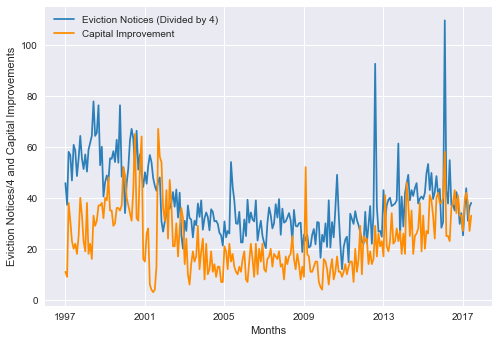

In [52]:
plt.show()

In [ ]:
plt.plot(new_merged_final.groupby('Month_Year').sum().reset_index()['Month_Year'],new_merged_final.groupby('Month_Year').sum().reset_index()['Eviction_Notice'].apply(lambda x: x/4.),label='Eviction Notices (Divided by 4)')
plt.plot(new_merged_final.groupby('Month_Year').sum().reset_index()['Month_Year'],new_merged_final.groupby('Month_Year').sum().reset_index()['Ground (landlord): Capital Improvement'],label='Capital Improvement, 6 months prior')
plt.title('Eviction Notices v. # of Capital Improvements Requests Six Month Prior')
plt.xlabel('Months')
plt.ylabel('Eviction Notices/10 and Capital Improvements')
plt.legend()



In [ ]:
plt.show()

In [ ]:
merged_year_prior = pd.merge(final_df,new_capital_df,how='left',left_on=['Address_Zipcode','datetime_one_year_prior'], right_on=['Petition Source Zipcode','Date Filed'])


In [ ]:
merged_year_prior[['Address_Zipcode','Eviction_Notice','Ground (landlord): Capital Improvement','Month_Year']]

In [ ]:
merged_dropped_year_prior = merged_year_prior.dropna(subset=['Ground (landlord): Capital Improvement'],inplace=False)


In [ ]:
new_merged_year_prior = merged_dropped_year_prior[['Eviction_Notice','Ground (landlord): Capital Improvement','Month_Year']]


In [ ]:
plt.plot(new_merged_year_prior.groupby('Month_Year').sum().reset_index()['Month_Year'],new_merged_year_prior.groupby('Month_Year').sum().reset_index()['Eviction_Notice'].apply(lambda x: x/4.),label='Eviction Notices (Divided by 4)')
plt.plot(new_merged_year_prior.groupby('Month_Year').sum().reset_index()['Month_Year'],new_merged_year_prior.groupby('Month_Year').sum().reset_index()['Ground (landlord): Capital Improvement'],label='Capital Improvement, 6 months prior')
plt.title('Eviction Notices v. # of Capital Improvements Requests One Year Prior')
plt.xlabel('Months')
plt.ylabel('Eviction Notices/4 and Capital Improvements')
plt.legend()


In [ ]:
plt.show()

In [ ]:
plt.